In [1]:
import os
os.system("python --version")
import yt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

print(yt.__version__)
os.system("python --version")
yt.set_log_level(40)        
"""
Possible values of set_log_level by increasing level:
        0 or "notset"
        1 or "all"
        10 or "debug"
        20 or "info"
        30 or "warning"
        40 or "error"
        50 or "critical"
"""


# The toggle_interactivity() function toggles interactive jupyter plots

yt.toggle_interactivity()

Python 3.9.18
4.1.4
Python 3.9.18
Using matplotlib backend: agg


In [3]:
## IMPORTING TIME SERIES DATA INTO VARIABLE ts
scratchPath = "/mnt/scratch/freem386/new_pgen_no_B/"
f0, fn = 0, 20
step, width = 1, 5 
files = []
for f in np.arange(f0, fn+1, step, dtype=int):
    files.append(scratchPath + "magpinch.out2." + str(f).zfill(width) + ".athdf")
# print(files)

# unit_base={"length_unit": (1.0,"pc"), "time_unit": (1.0,"s*pc/km"), "mass_unit": (2.38858753789e-24,"g/cm**3*pc**3")}
ts = yt.DatasetSeries(files)
print("number of files: ", len(files))

number of files:  21


In [10]:
## Checking derived or innate field lists
# ds = ts[0]
# ds.derived_field_list
# print(ds.field_list)
# ad = ds.all_data()
# test = np.array(ad[('athena_pp', 'vel1')])


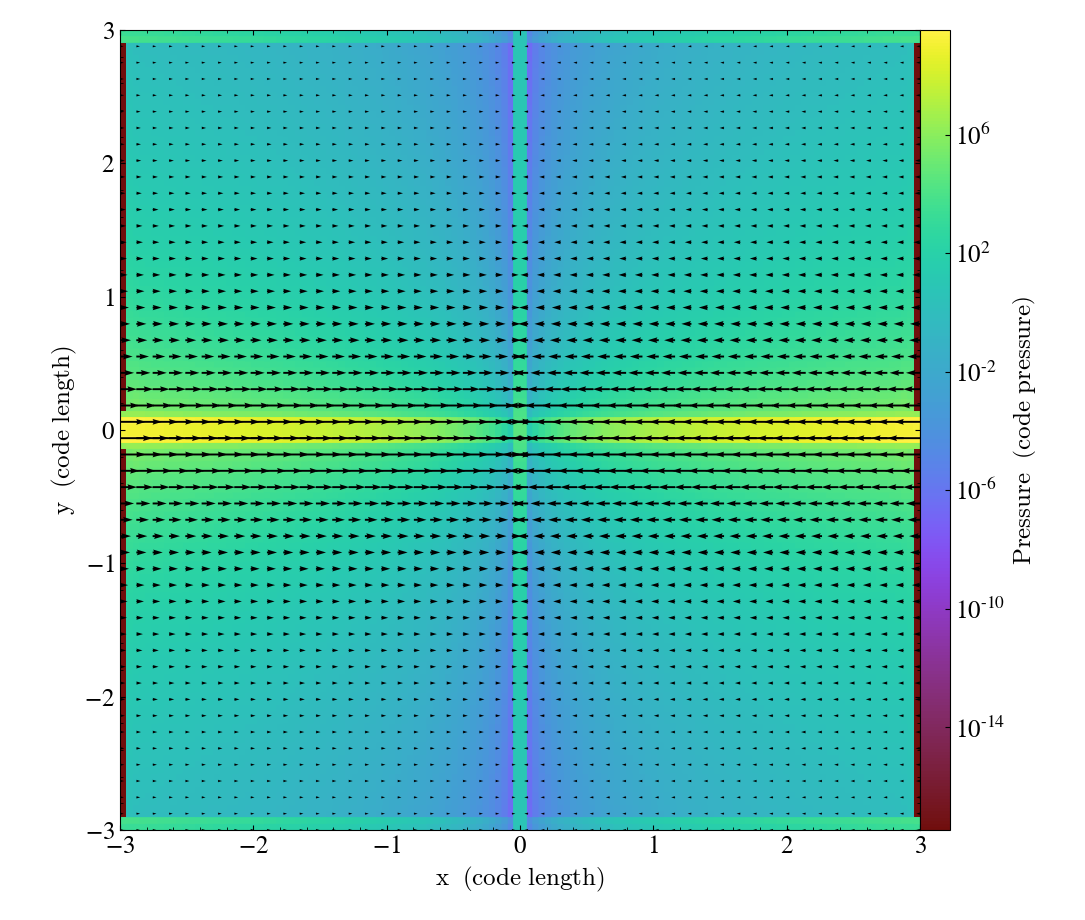

In [18]:
## Plotting a single dataset
index = 1
ds = ts[index]

# p = yt.plot_2d(ds, ("gas","density"))
p = yt.plot_2d(ds, ("gas", "pressure"))
# p = yt.plot_2d(ds, ('gas', 'kT'))
# p = yt.plot_2d(ds, ("gas", "magnetic_pressure"))
# p = yt.plot_2d(ds, ("gas", "velocity_magnitude"))
# p = yt.plot_2d(ds, ("athena_pp", "vel2"))
# p = yt.plot_2d(ds, ("gas", "velocity_x"))
# p = yt.plot_2d(ds, ("gas", "mach_number"))

# p.set_zlim(("gas", "density"), zmin=1e-4, zmax=1e5)
# p.annotate_grids()

# p.annotate_magnetic_field()
p.annotate_streamlines(("gas", "magnetic_field_x"), ("gas", "magnetic_field_y"))

p.annotate_velocity()
# p.annotate_streamlines(("gas", "velocity_x"), ("gas", "velocity_y"))

# p.pan([3, 0])
# p.zoom(1)

## Field list output from magpinch problems:
('athena_pp', 'Bcc1'), ('athena_pp', 'Bcc2'), ('athena_pp', 'Bcc3'),
('athena_pp', 'cell_volume'),
('athena_pp', 'dx'), ('athena_pp', 'dy'), ('athena_pp', 'dz'),
('athena_pp', 'path_element_x'), ('athena_pp', 'path_element_y'), ('athena_pp', 'path_element_z'),
('athena_pp', 'press'),
('athena_pp', 'rho'),
('athena_pp', 'vel1'), ('athena_pp', 'vel2'), ('athena_pp', 'vel3'),
('athena_pp', 'volume'),
('athena_pp', 'x'), ('athena_pp', 'y'), ('athena_pp', 'z'),
('gas', 'alfven_speed'),
('gas', 'angular_momentum_magnitude'),
('gas', 'angular_momentum_x'), ('gas', 'angular_momentum_y'), ('gas', 'angular_momentum_z'),
('gas', 'averaged_density'),
('gas', 'baroclinic_vorticity_magnitude'),
('gas', 'baroclinic_vorticity_x'), ('gas', 'baroclinic_vorticity_y'), ('gas', 'baroclinic_vorticity_z'),
('gas', 'cell_mass'), ('gas', 'cell_volume'),
('gas', 'courant_time_step'),
('gas', 'density'),
('gas', 'density_gradient_magnitude'), ('gas', 'density_gradient_x'), ('gas', 'density_gradient_y'), ('gas', 'density_gradient_z'),
('gas', 'dx'), ('gas', 'dy'), ('gas', 'dynamical_time'), ('gas', 'dz'),
('gas', 'four_velocity_magnitude'), ('gas', 'four_velocity_t'), ('gas', 'four_velocity_x'), ('gas', 'four_velocity_y'), ('gas', 'four_velocity_z'),
('gas', 'jeans_mass'),
('gas', 'kT'),
('gas', 'kinetic_energy_density'),
('gas', 'lorentz_factor'),
('gas', 'mach_alfven'), ('gas', 'mach_number'),
('gas', 'magnetic_energy_density'), ('gas', 'magnetic_field_los'), ('gas', 'magnetic_field_magnitude'),
('gas', 'magnetic_field_strength'), ('gas', 'magnetic_field_x'), ('gas', 'magnetic_field_y'), ('gas', 'magnetic_field_z'),
('gas', 'magnetic_pressure'),
('gas', 'mass'), ('gas', 'mean_molecular_weight'),
('gas', 'momentum_density_x'), ('gas', 'momentum_density_y'), ('gas', 'momentum_density_z'),
('gas', 'momentum_x'), ('gas', 'momentum_y'), ('gas', 'momentum_z'),
('gas', 'number_density'),
('gas', 'path_element_x'), ('gas', 'path_element_y'), ('gas', 'path_element_z'),
('gas', 'plasma_beta'),
('gas', 'pressure'), ('gas', 'pressure_gradient_magnitude'), ('gas', 'pressure_gradient_x'), ('gas', 'pressure_gradient_y'), ('gas', 'pressure_gradient_z'),
('gas', 'relative_magnetic_field_x'), ('gas', 'relative_magnetic_field_y'), ('gas', 'relative_magnetic_field_z'),
('gas', 'relative_velocity_x'), ('gas', 'relative_velocity_y'), ('gas', 'relative_velocity_z'),
('gas', 'shear'), ('gas', 'shear_criterion'), 
('gas', 'shear_mach'), ('gas', 'sound_speed'),
('gas', 'specific_angular_momentum_magnitude'), ('gas', 'specific_angular_momentum_x'), ('gas', 'specific_angular_momentum_y'), ('gas', 'specific_angular_momentum_z'),
('gas', 'specific_thermal_energy'),
('gas', 'temperature'),
('gas', 'velocity_los'),
('gas', 'velocity_magnitude'), ('gas', 'velocity_x'), ('gas', 'velocity_y'), ('gas', 'velocity_z'),
('gas', 'volume'),
('gas', 'vorticity_magnitude'), ('gas', 'vorticity_squared'),
('gas', 'vorticity_x'), ('gas', 'vorticity_y'), ('gas', 'vorticity_z'),
('gas', 'x'), ('gas', 'y'), ('gas', 'z'),
('index', 'cell_volume'),
('index', 'cylindrical_radius'),
('index', 'cylindrical_theta'),
('index', 'cylindrical_z'),
('index', 'dx'), ('index', 'dy'), ('index', 'dz'),
('index', 'grid_indices'), ('index', 'grid_level'),
('index', 'morton_index'),
('index', 'ones'), ('index', 'ones_over_dx'),
('index', 'path_element_x'), ('index', 'path_element_y'), ('index', 'path_element_z'),
('index', 'radius'), ('index', 'spherical_phi'), ('index', 'spherical_radius'), ('index', 'spherical_theta'),
('index', 'virial_radius_fraction'),
('index', 'volume'),
('index', 'x'), ('index', 'y'), ('index', 'z'), 
('index', 'zeros')

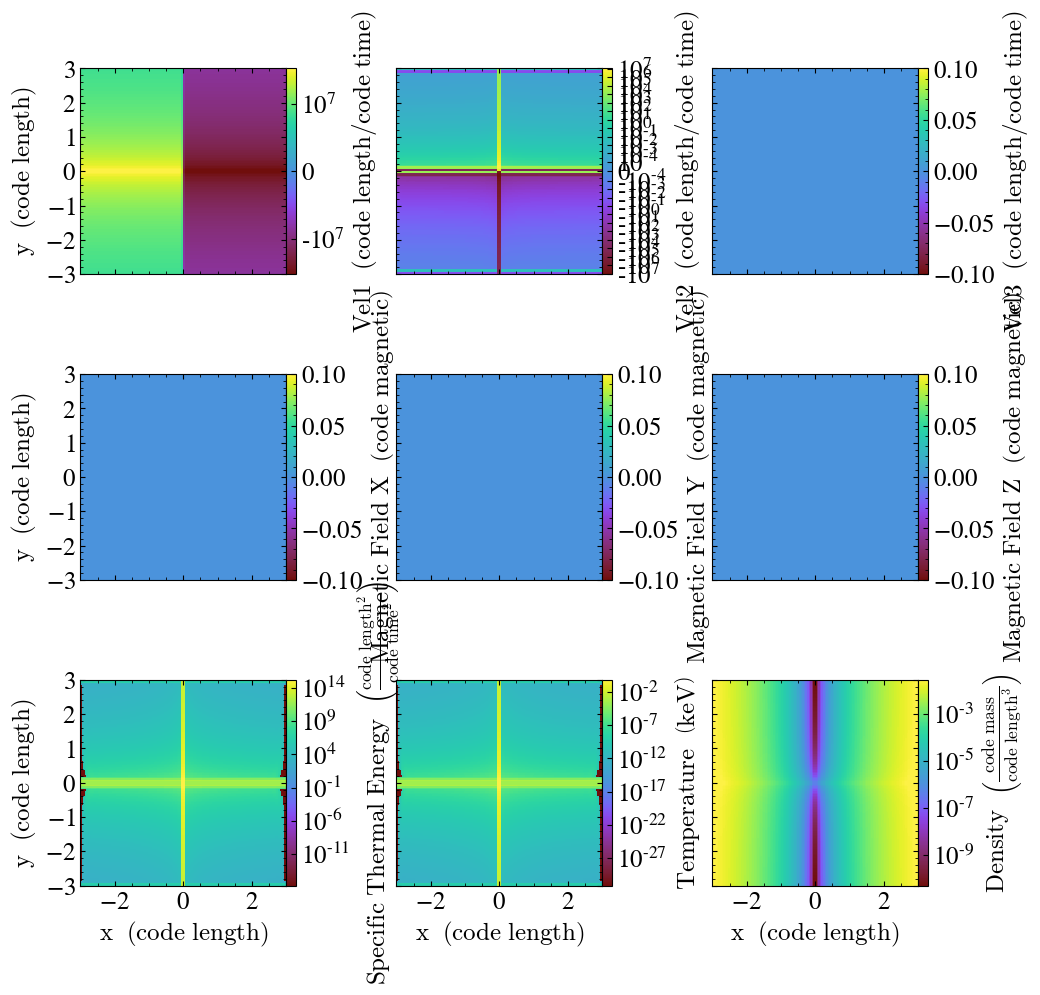

In [7]:
## Plotting a 2x2 grid of YT fields
index = 10

ds = ts[index]

fields = [
    ('athena_pp', 'vel1'), ('athena_pp', 'vel2'), ('athena_pp', 'vel3'),
    ('gas', 'magnetic_field_x'), ('gas', 'magnetic_field_y'), ('gas', 'magnetic_field_z'),
    ('gas', 'specific_thermal_energy'),
    ("gas", "kT"),
    ("gas", "density"),
]

p = yt.SlicePlot(ds, "z", fields)

# this returns a matplotlib figure with an ImageGrid and the slices
# added to the grid of axes (in this case, 2x2)

fig = p.export_to_mpl_figure((3, 3))

fig.tight_layout()

# fig.savefig("unfixed_pgen_no_B_20.png")

fig